# Objective of the project 🚀

My objective is to create a machine learning model for object classification and then, try and compare it with a convolutional neural network (CNN) for images. For that, I will use Spark MLlib to train and evaluate the model. Secondly, create the CNN and compare both 🪐




# First Steps

## Download the data

The source of the data is: https://skyserver.sdss.org/CasJobs/
It is necessary to register and login a user to download the data you want. Then, you have to make a query specifying:
- Amount of rows
- Columns
- Where to keep the csv
- The database

As I want to get as much as possible data, I will not a maximum of rows.

I also add a "where" so I can get only data from planets, galaxies and stars:
- type = 3: Galaxies
- type = 6: Stars

and I downloaded the dataset to start working with it.


![](notebookImages/img1.png)

## Understanding the data

The columns we have are:
- objID: Unique identifier of the object → TYPE bigInt
- ra: Right ascension → TYPE float
- dec: Declination → TYPE float
- petroRad: Petrosian radius, used to know the size of galaxies in astronomical pictures. It is the amount of light that a galaxy emits in a sepecific radius. Very used because it is independent of the distance and brightness. We use different photometric filters:
    - petroRad_u: Near-ultraviolet
    - petroRad_g: Blue-Green
    - petroRad_r: Red
    - petroRad_i: Near-infrared
    - petroRad_z: Deeper infrared
 → TYPE: Real

- modelMag: Brightness measure adjusted to a galaxy model. Usual for galaxies. Also for all filters (u, g, r, i and z) → TYPE Real
- psfMag: Brightness measure based on the point source light profile. Usual for stars. Also for all filters (u, g, r, i and z) → TYPE Real
- u_g: (modelMag_u - modelMag_g)
- g_r: (modelMag_g - modelMag_r)
- r_i: (modelMag_r - modelMag_i)
- i_z: (modelMag_i - modelMag_z)
- fracDeV: The amount of brightness that the object has in the De Vaucouleurs profile. Also for all filters (u, g, r, i and z) → TYPE Real
- flags: Bit comination that explains different characteristics of the object. If we convert it to binary and check SDSS documentarion, we get a meaning for each bit → TYPE bigInt
- clean: Indicator that tell us if the object was cleaned → TYPE int



### What for?

PetroRad:
- Stars: Small and constant in all filters.
- Galaxies: Bigger and variates depending on the wavelengths.

ModelMag and psfMag:
- In the red filter:
    - Stars: modelMag_r ≈ psfMag_r
    - Galaxies: modelMag_r > psfMag_r
- In other filers:
    - Galaxies are usuarlly more red  (modelMag_g - modelMag_r is big).
    - Stars has different colors depending on their type.

fracDeV:
- Stars: fracDeV ≈ 0.
- Galaxies: fracDeV ≈ 1 (eliptic) or fracDeV < 1 (espiral).



# Spark

## Spark configuration

First, we need to create a spark sesion in case there is no one or get if there exists: "getOrCreate". I also decided to create a log in case there is any error during the process.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("bigDataAstronomyProject") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "1") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

your 131072x1 screen size is bogus. expect trouble
25/04/01 21:01:57 WARN Utils: Your hostname, SS22-3006967600 resolves to a loopback address: 127.0.1.1; using 172.20.232.160 instead (on interface eth0)
25/04/01 21:01:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/01 21:01:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Then, we need to read de csv data.

In [2]:
import config

df = spark.read.csv(config.DATA_PATH, header=True)
print(df.count())
#df2 = spark.read.csv(config.DATA_PATH2, header=True)
#print(df2.count())

#df = df.union(df2)
#print(df.count())

100000


Now, we are going to check if the data is correctly loaded.

In [3]:
df.show()

+-------------------+----------------+----------------+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---------+-----------+-------------+----------+---------+---------+----------+----------+---------+-----------------+-----+
|              objID|              ra|             dec|type|petroRad_u|petroRad_g|petroRad_r|petroRad_i|petroRad_z|modelMag_u|modelMag_g|modelMag_r|modelMag_i|modelMag_z|psfMag_u|psfMag_g|psfMag_r|psfMag_i|psfMag_z|      u_g|        g_r|          r_i|       i_z|fracDeV_u|fracDeV_g| fracDeV_r| fracDeV_i|fracDeV_z|            flags|clean|
+-------------------+----------------+----------------+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---------+-----------+-------------+----------+---------+---------+----------+----------+---------+--------

The schema and the chacacteristics of the data.

In [4]:
df.printSchema()

root
 |-- objID: string (nullable = true)
 |-- ra: string (nullable = true)
 |-- dec: string (nullable = true)
 |-- type: string (nullable = true)
 |-- petroRad_u: string (nullable = true)
 |-- petroRad_g: string (nullable = true)
 |-- petroRad_r: string (nullable = true)
 |-- petroRad_i: string (nullable = true)
 |-- petroRad_z: string (nullable = true)
 |-- modelMag_u: string (nullable = true)
 |-- modelMag_g: string (nullable = true)
 |-- modelMag_r: string (nullable = true)
 |-- modelMag_i: string (nullable = true)
 |-- modelMag_z: string (nullable = true)
 |-- psfMag_u: string (nullable = true)
 |-- psfMag_g: string (nullable = true)
 |-- psfMag_r: string (nullable = true)
 |-- psfMag_i: string (nullable = true)
 |-- psfMag_z: string (nullable = true)
 |-- u_g: string (nullable = true)
 |-- g_r: string (nullable = true)
 |-- r_i: string (nullable = true)
 |-- i_z: string (nullable = true)
 |-- fracDeV_u: string (nullable = true)
 |-- fracDeV_g: string (nullable = true)
 |-- fracDe

As all columns are string, we need to convert them into their type. For that:

In [5]:
from pyspark.sql.functions import col

df = df.withColumn("objID", col("objID").cast("long")) \
       .withColumn("ra", col("ra").cast("float")) \
       .withColumn("dec", col("dec").cast("float")) \
       .withColumn("petroRad_u", col("petroRad_u").cast("float")) \
       .withColumn("petroRad_g", col("petroRad_g").cast("float")) \
       .withColumn("petroRad_r", col("petroRad_r").cast("float")) \
       .withColumn("petroRad_i", col("petroRad_i").cast("float")) \
       .withColumn("petroRad_z", col("petroRad_z").cast("float")) \
       .withColumn("modelMag_u", col("modelMag_u").cast("float")) \
       .withColumn("modelMag_g", col("modelMag_g").cast("float")) \
       .withColumn("modelMag_r", col("modelMag_r").cast("float")) \
       .withColumn("modelMag_i", col("modelMag_i").cast("float")) \
       .withColumn("modelMag_z", col("modelMag_z").cast("float")) \
       .withColumn("psfMag_u", col("psfMag_u").cast("float")) \
       .withColumn("psfMag_g", col("psfMag_g").cast("float")) \
       .withColumn("psfMag_r", col("psfMag_r").cast("float")) \
       .withColumn("psfMag_i", col("psfMag_i").cast("float")) \
       .withColumn("psfMag_z", col("psfMag_z").cast("float")) \
       .withColumn("u_g", col("u_g").cast("float")) \
       .withColumn("g_r", col("g_r").cast("float")) \
       .withColumn("r_i", col("r_i").cast("float")) \
       .withColumn("i_z", col("i_z").cast("float")) \
       .withColumn("fracDeV_u", col("fracDeV_u").cast("float")) \
       .withColumn("fracDeV_g", col("fracDeV_g").cast("float")) \
       .withColumn("fracDeV_r", col("fracDeV_r").cast("float")) \
       .withColumn("fracDeV_i", col("fracDeV_i").cast("float")) \
       .withColumn("fracDeV_z", col("fracDeV_z").cast("float")) \
       .withColumn("flags", col("flags").cast("long")) \
       .withColumn("clean", col("clean").cast("int"))

df.printSchema()

root
 |-- objID: long (nullable = true)
 |-- ra: float (nullable = true)
 |-- dec: float (nullable = true)
 |-- type: string (nullable = true)
 |-- petroRad_u: float (nullable = true)
 |-- petroRad_g: float (nullable = true)
 |-- petroRad_r: float (nullable = true)
 |-- petroRad_i: float (nullable = true)
 |-- petroRad_z: float (nullable = true)
 |-- modelMag_u: float (nullable = true)
 |-- modelMag_g: float (nullable = true)
 |-- modelMag_r: float (nullable = true)
 |-- modelMag_i: float (nullable = true)
 |-- modelMag_z: float (nullable = true)
 |-- psfMag_u: float (nullable = true)
 |-- psfMag_g: float (nullable = true)
 |-- psfMag_r: float (nullable = true)
 |-- psfMag_i: float (nullable = true)
 |-- psfMag_z: float (nullable = true)
 |-- u_g: float (nullable = true)
 |-- g_r: float (nullable = true)
 |-- r_i: float (nullable = true)
 |-- i_z: float (nullable = true)
 |-- fracDeV_u: float (nullable = true)
 |-- fracDeV_g: float (nullable = true)
 |-- fracDeV_r: float (nullable = tr

Now that we have all the structure, we are going to explore and clean the data.

## Data cleaning and understanding

In principle, the data is cleaned because we get it from CasJobs and we apply clear filter to get good data. 
However, we are going to check whether there is any null value and the amount of galaxies and stars.  

In [6]:
from pyspark.sql.functions import col, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+---+---+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---+---+---+---+---------+---------+---------+---------+---------+-----+-----+
|objID| ra|dec|type|petroRad_u|petroRad_g|petroRad_r|petroRad_i|petroRad_z|modelMag_u|modelMag_g|modelMag_r|modelMag_i|modelMag_z|psfMag_u|psfMag_g|psfMag_r|psfMag_i|psfMag_z|u_g|g_r|r_i|i_z|fracDeV_u|fracDeV_g|fracDeV_r|fracDeV_i|fracDeV_z|flags|clean|
+-----+---+---+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---+---+---+---+---------+---------+---------+---------+---------+-----+-----+
|    0|  0|  0|   0|         0|         0|         0|         0|         0|         0|         0|         0|         0|         0|       0|       0|       0|       0|       0|  0|  0|  0|  0|        0|        0|        0|        0|       

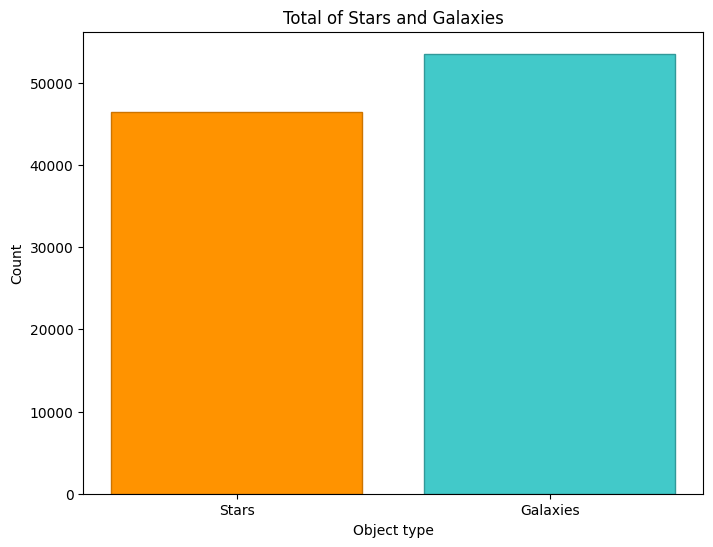

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

number_stars = df.filter(df.type == 6).count()
number_galaxies = df.filter(df.type == 3).count()

#Convert the data into a dataframe to make the plot
data = pd.DataFrame({
    "type": ["Stars", "Galaxies"],
    "count": [number_stars, number_galaxies]
})


plt.figure(figsize=(8, 6))
plt.bar(data["type"], data["count"], color=["#ff9300", "#42c9c9"], edgecolor=["#cc7400", "#329999"])
plt.xlabel("Object type")
plt.ylabel("Count")
plt.title("Total of Stars and Galaxies")


plt.show()

As we can see, there is no null values and the amount of galaxies are less than the amount of stars, which make sense.

The next step is to change "type" label. As it is a binary classification, we will update stars to 0 and galaxies to 1.

In [8]:
df = df.withColumn("type", when(col("type") == 3,1).otherwise(0))

In [9]:
df_stars = df.filter(df["type"] == 0)
df_galaxies = df.filter(df["type"] == 1)

#Print to know the conversion is correctly done
df_stars.show(5)
df_galaxies.show(5)

+-------------------+----------+---------+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+--------+---------+------------+----------+---------+---------+---------+---------+---------+-----------------+-----+
|              objID|        ra|      dec|type|petroRad_u|petroRad_g|petroRad_r|petroRad_i|petroRad_z|modelMag_u|modelMag_g|modelMag_r|modelMag_i|modelMag_z|psfMag_u|psfMag_g|psfMag_r|psfMag_i|psfMag_z|     u_g|      g_r|         r_i|       i_z|fracDeV_u|fracDeV_g|fracDeV_r|fracDeV_i|fracDeV_z|            flags|clean|
+-------------------+----------+---------+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+--------+---------+------------+----------+---------+---------+---------+---------+---------+-----------------+-----+
|1237645879562928227| 15.984567|1.261529

In [10]:
df_ml_model = df.select("type", "petroRad_u", "petroRad_g", "petroRad_r", "petroRad_i", "petroRad_z",
                        "modelMag_u", "modelMag_g", "modelMag_r", "modelMag_i", "modelMag_z",
                        "psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z",
                        "u_g", "g_r", "r_i", "i_z",
                        "fracDeV_u", "fracDeV_g", "fracDeV_r", "fracDeV_i", "fracDeV_z")

df_ml_model.printSchema()

root
 |-- type: integer (nullable = false)
 |-- petroRad_u: float (nullable = true)
 |-- petroRad_g: float (nullable = true)
 |-- petroRad_r: float (nullable = true)
 |-- petroRad_i: float (nullable = true)
 |-- petroRad_z: float (nullable = true)
 |-- modelMag_u: float (nullable = true)
 |-- modelMag_g: float (nullable = true)
 |-- modelMag_r: float (nullable = true)
 |-- modelMag_i: float (nullable = true)
 |-- modelMag_z: float (nullable = true)
 |-- psfMag_u: float (nullable = true)
 |-- psfMag_g: float (nullable = true)
 |-- psfMag_r: float (nullable = true)
 |-- psfMag_i: float (nullable = true)
 |-- psfMag_z: float (nullable = true)
 |-- u_g: float (nullable = true)
 |-- g_r: float (nullable = true)
 |-- r_i: float (nullable = true)
 |-- i_z: float (nullable = true)
 |-- fracDeV_u: float (nullable = true)
 |-- fracDeV_g: float (nullable = true)
 |-- fracDeV_r: float (nullable = true)
 |-- fracDeV_i: float (nullable = true)
 |-- fracDeV_z: float (nullable = true)



In [11]:
type(df_ml_model)

pyspark.sql.dataframe.DataFrame

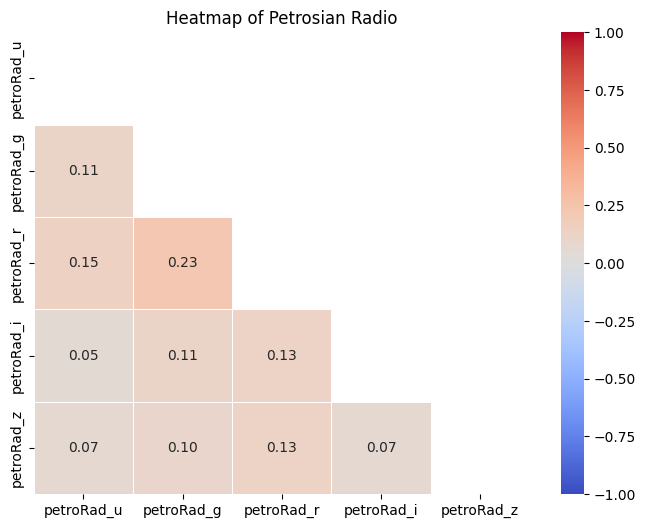

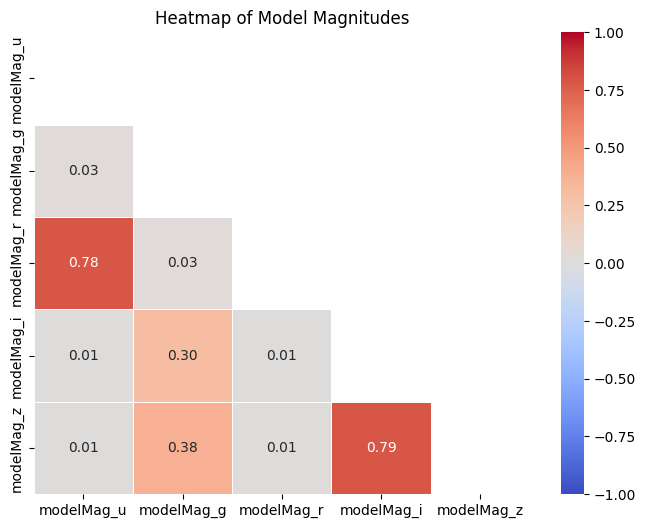

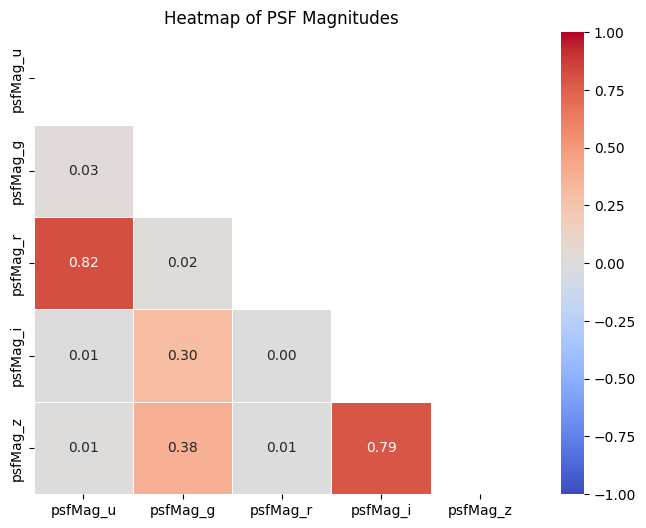

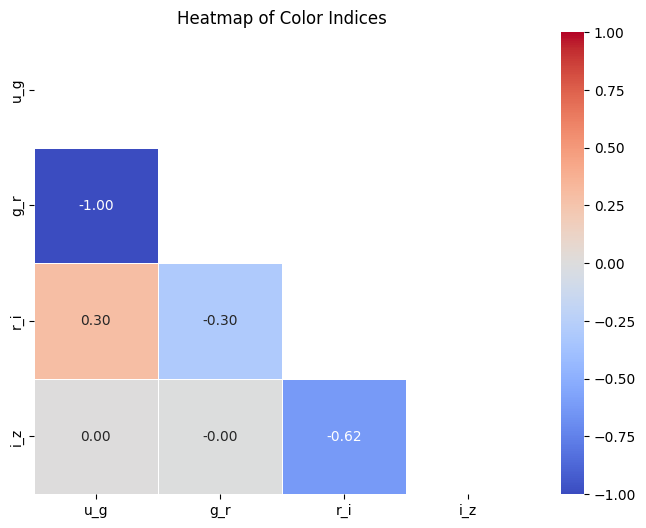

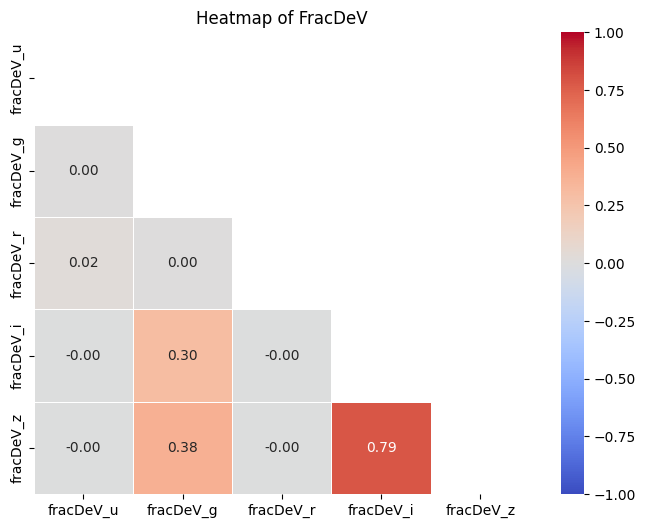

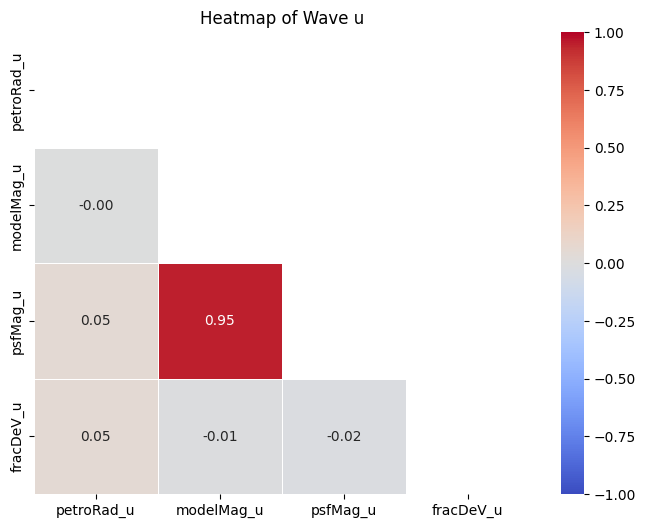

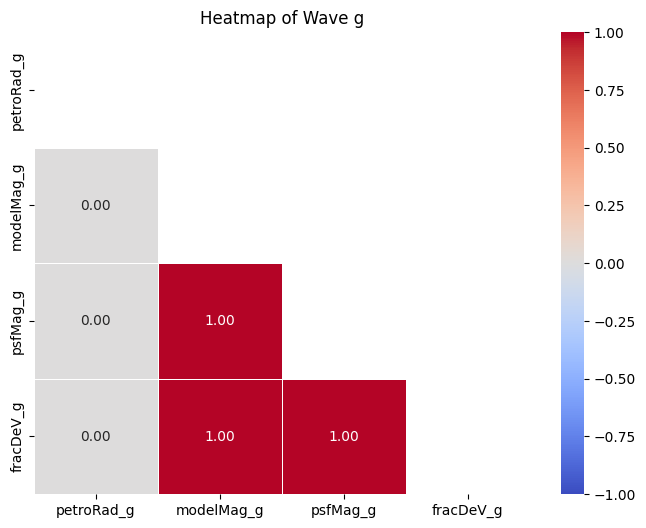

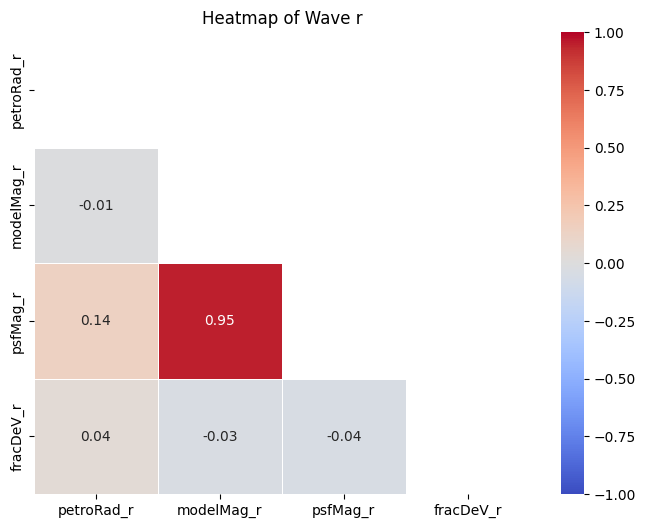

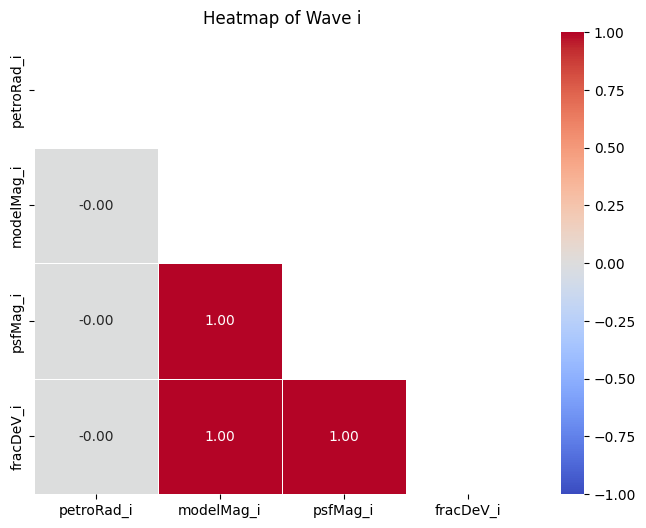

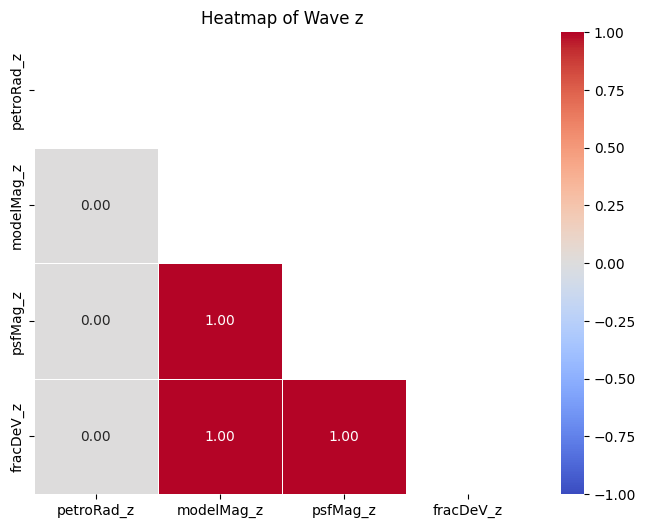

In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df_pd = df_ml_model.toPandas()

#Remove the column type, it is not numerical
df_corr = df_pd.drop(columns=["type"]).corr()

groups = {
    "Petrosian Radio": ["petroRad_u", "petroRad_g", "petroRad_r", "petroRad_i", "petroRad_z"],
    "Model Magnitudes": ["modelMag_u", "modelMag_g", "modelMag_r", "modelMag_i", "modelMag_z"],
    "PSF Magnitudes": ["psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z"],
    "Color Indices": ["u_g", "g_r", "r_i", "i_z"],
    "FracDeV": ["fracDeV_u", "fracDeV_g", "fracDeV_r", "fracDeV_i", "fracDeV_z"],
    "Wave u": ["petroRad_u", "modelMag_u", "psfMag_u", "fracDeV_u"],
    "Wave g": ["petroRad_g", "modelMag_g", "psfMag_g", "fracDeV_g"],
    "Wave r": ["petroRad_r", "modelMag_r", "psfMag_r", "fracDeV_r"],
    "Wave i": ["petroRad_i", "modelMag_i", "psfMag_i", "fracDeV_i"],
    "Wave z": ["petroRad_z", "modelMag_z", "psfMag_z", "fracDeV_z"]

}

def plot_heatmap(df, cols, title):
    df_corr = df[cols].corr()  # Calcular matriz de correlación
    mask = np.triu(np.ones_like(df_corr, dtype=bool))  # Ocultar parte superior

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
    plt.title(f"Heatmap of {title}")
    plt.show()

# Graficar heatmaps por grupo
for group_name, columns in groups.items():
    plot_heatmap(df_pd, columns, group_name)

## Spark ML

In [13]:
import set_seed


set_seed.set_seed(132)

As our objective is to create a machine learning model, we need to convert the data in a correct format: Vectors.

In [14]:
from pyspark.ml.feature import VectorAssembler

features = df_ml_model.columns[1:] #We don't get the type beacuse is the result we want to get.
assembler = VectorAssembler(inputCols = features, outputCol = "features") #Convert features list as a vector
df_ml_model = assembler.transform(df_ml_model) #Apply transformation
df_ml_model = df_ml_model.select("features", "type")

df_ml_model.head(5)

[Row(features=DenseVector([2.2921, 1.7076, 1.6485, 1.6654, 1.729, 21.2414, 18.8804, 17.5719, 16.3516, 15.7034, 21.1858, 18.878, 17.5816, 16.3522, 15.7095, 2.361, 1.3086, 1.2203, 0.6482, 0.0, 0.0, 1.0, 0.0, 0.0]), type=0),
 Row(features=DenseVector([1.4166, 1.7066, 1.8061, 1.6989, 1.59, 20.9405, 19.8125, 19.5077, 19.4671, 19.4443, 20.93, 19.8136, 19.5282, 19.4942, 19.4514, 1.128, 0.3047, 0.0407, 0.0228, 0.0, 0.0, 1.0, 0.9682, 0.0]), type=0),
 Row(features=DenseVector([1.7877, 2.5021, 2.5175, 2.4911, 2.9252, 20.9695, 20.2914, 19.3678, 18.8639, 18.4555, 21.3143, 20.775, 19.8938, 19.3627, 18.9478, 0.6781, 0.9236, 0.5039, 0.4084, 1.0, 0.5368, 0.631, 0.484, 0.417]), type=1),
 Row(features=DenseVector([3.0812, 1.5711, 1.6398, 1.752, 1.6438, 22.722, 20.319, 19.0538, 18.4886, 18.2401, 22.6338, 20.3004, 19.0465, 18.4912, 18.2252, 2.4031, 1.2651, 0.5652, 0.2485, 1.0, 1.0, 1.0, 1.0, 0.0]), type=0),
 Row(features=DenseVector([2.6302, 2.494, 2.2824, 2.8315, 3.7433, 20.8501, 20.6889, 20.2304, 20.26, 

Now, we are going to divide the dataset into train and test, so we can get the accuracy of the model.

In [15]:
train_data, test_data = df_ml_model.randomSplit([0.8, 0.2], seed = 132)

We are going to try different models to check which is the best for our case.

In [16]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC

#Define different models
models = {
    "Logistic Regression": LogisticRegression(labelCol="type", featuresCol="features"),
    "Decision Tree": DecisionTreeClassifier(labelCol="type", featuresCol="features"),
    "Random Forest": RandomForestClassifier(labelCol="type", featuresCol="features", numTrees=5),
    "Gradient Boosted Trees": GBTClassifier(labelCol="type", featuresCol="features"),
    "Linear SVM": LinearSVC(labelCol="type", featuresCol="features")
}

Now, we are going to calculate the **AUC evaluator** for model and look how well they are doing. I decided to use AUC because it is a good technique to use for binary classification, especially when classes are unbalanced.

Remember that the ROC curve gives a visual representation between the true prositive rate and false positive rate at different thresholds. So, it tell us how well the model can detect true positive and avoid false positives. Moreover, AUC is one scalar value from 0 to  that tell how the model performs globally. AUC represents the area beneath the curve.
- AUC = 0.5 ⭢ Random Predictions
- AUC > 0.5 ⭢ Increasingly good predictions
- AUC = 1 ⭢ Perfect predictions



![](notebookImages/img2.png)

In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import auc

evaluator = BinaryClassificationEvaluator(labelCol="type", metricName="areaUnderROC")

for name, model in models.items():
    model_trained = model.fit(train_data)
    predictions = model_trained.transform(test_data)
    auc = evaluator.evaluate(predictions)
    print(f"{name}: AUC = {auc:.4f}")

Logistic Regression: AUC = 0.9945


Decision Tree: AUC = 0.9558


Random Forest: AUC = 0.9892


Gradient Boosted Trees: AUC = 0.9935


Linear SVM: AUC = 0.9941


The model Linear SVM does not have 'probability' column so it will not be in the graphic.


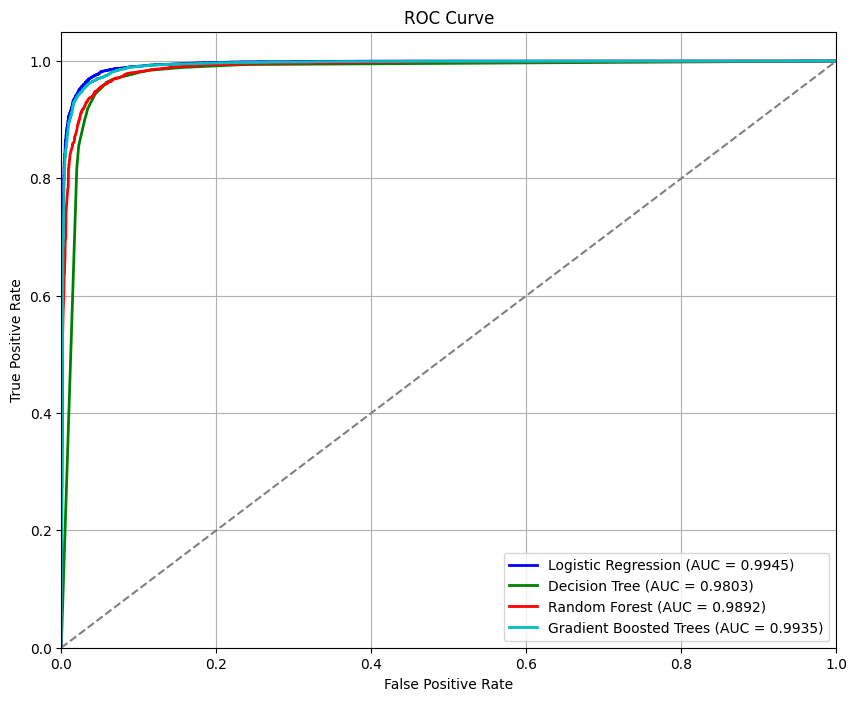

In [18]:
from sklearn.metrics import roc_curve, auc

#Create the figure
plt.figure(figsize=(10, 8))

#Different colors for the different models
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

#For each model compute the AUC
for idx, (name, model) in enumerate(models.items()):
    model_trained = model.fit(train_data)
    predictions = model_trained.transform(test_data) #Predicted class (0 or 1)

    #Check if the model has "probability" column because some of them (SVG for example) do not
    if "probability" in predictions.columns:
        #Get the whole probability vector, convert it into rdd and select the probability for the positive (real) prediction
        prob_positives = predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()
        #Get the label for each prediction
        true_labels = predictions.select("type").rdd.map(lambda row: row[0]).collect()

        #Calculate ROC curve
        fpr, tpr, _ = roc_curve(true_labels, prob_positives)
        roc_auc = auc(fpr, tpr)

        #Plot it
        plt.plot(fpr, tpr, color=colors[idx % len(colors)], lw=2, label=f'{name} (AUC = {roc_auc:.4f})')
    else:
        print(f"The model {name} does not have 'probability' column so it will not be in the graphic.")

#Different parameters to personalize the plot
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  #Diagonal line of "random"
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()

plt.show()

The AUC for Decision Tree is different. That is because PySpark uses BinaryClassificationEvaluator, so it is evaluating with the class prediction (star or galaxy), whereas scikit-learn uses the predicted probabilities to calculate the AUC. That is why scikit-learn should be more precise.

Taking this into account, the best AUC is the one for logistic regression so we will use that model in order to make our predictions. 

Then, as our model has a very high AUC, we need to ensure that it is not overfitted. A high AUC does not necessarily mean good generalization; it could indicate that the model memorized the training data.

To ensure about this, we will compute the confusion matrix for training and test sets. Comparing both we will know if the model is performing well or not with unseen data. We will use plots to visualize the matrices in order to make an easier and more interpetable comparison.

In [19]:
lr = LogisticRegression(labelCol="type", featuresCol="features")
lr_model = lr.fit(train_data)

predictions_log_train = lr_model.transform(train_data)
predictions_log_test = lr_model.transform(test_data)

auc_train = evaluator.evaluate(predictions_log_train)
auc_test = evaluator.evaluate(predictions_log_test)

print(f"Logistic Regression (Train): AUC = {auc_train:.4f}\n")
print(f"Logistic Regression (Test): AUC = {auc_test:.4f}")

Logistic Regression (Train): AUC = 0.9947

Logistic Regression (Test): AUC = 0.9945


As we can see, the difference is almost non-existent which is good because this suggests that the model is generalizing correctly, data for train and test set are representative of the data. However, as it is a very high AUC, we can verify the confusion matrix in order to know if the model is correctly classifying. To make this, we will use the plot of the confusion matrix to visualize to get a conclusion in a easier and more interpetable way.

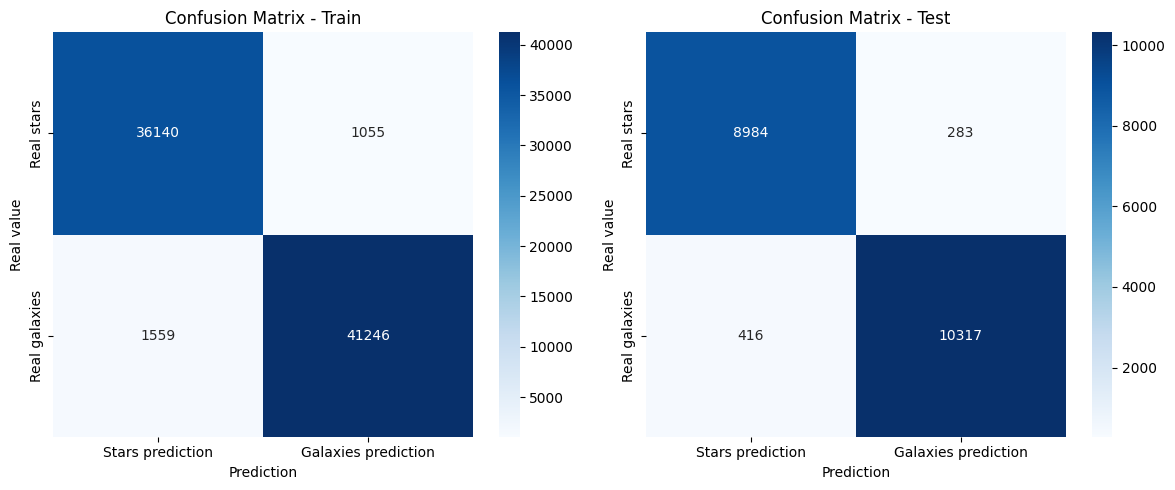

In [20]:
from pyspark.sql import functions as F
import seaborn as sns
import numpy as np

#Divide true positives, true negatives, false positives and false negatives
##Train
true_galaxies_train = predictions_log_train.filter((F.col("type") == 1) & (F.col("prediction") == 1)).count()
true_stars_train = predictions_log_train.filter((F.col("type") == 0) & (F.col("prediction") == 0)).count()
false_stars_train = predictions_log_train.filter((F.col("type") == 0) & (F.col("prediction") == 1)).count()
false_galaxies_train = predictions_log_train.filter((F.col("type") == 1) & (F.col("prediction") == 0)).count()

#Creating the confusion matrix
conf_matrix_values_train = [[true_stars_train, false_stars_train], [false_galaxies_train, true_galaxies_train]]


##Test
true_galaxies_test = predictions_log_test.filter((F.col("type") == 1) & (F.col("prediction") == 1)).count()
true_stars_test = predictions_log_test.filter((F.col("type") == 0) & (F.col("prediction") == 0)).count()
false_stars_test = predictions_log_test.filter((F.col("type") == 0) & (F.col("prediction") == 1)).count()
false_galaxies_test = predictions_log_test.filter((F.col("type") == 1) & (F.col("prediction") == 0)).count()

#Creating the confusion matrix
conf_matrix_values_test = [[true_stars_test, false_stars_test], [false_galaxies_test, true_galaxies_test]]


#Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  #Create two plots in 1 line

#Train confusion matrix
ax1 = sns.heatmap(np.array(conf_matrix_values_train), annot=True, fmt="d", cmap="Blues",
                   xticklabels=["Stars prediction", "Galaxies prediction"],
                   yticklabels=["Real stars", "Real galaxies"], ax=axes[0]) #Put in the axe 0, the left one
ax1.set_xlabel("Prediction")
ax1.set_ylabel("Real value")
ax1.set_title("Confusion Matrix - Train")

#Test confusion matrix
ax2 = sns.heatmap(np.array(conf_matrix_values_test), annot=True, fmt="d", cmap="Blues",
                   xticklabels=["Stars prediction", "Galaxies prediction"],
                   yticklabels=["Real stars", "Real galaxies"], ax=axes[1]) #Put in the axe 0, the right one
ax2.set_xlabel("Prediction")
ax2.set_ylabel("Real value")
ax2.set_title("Confusion Matrix - Test")


plt.tight_layout()
plt.show()


To detect if there is or not overfitting, we need to compare the error rate in train and test set. 

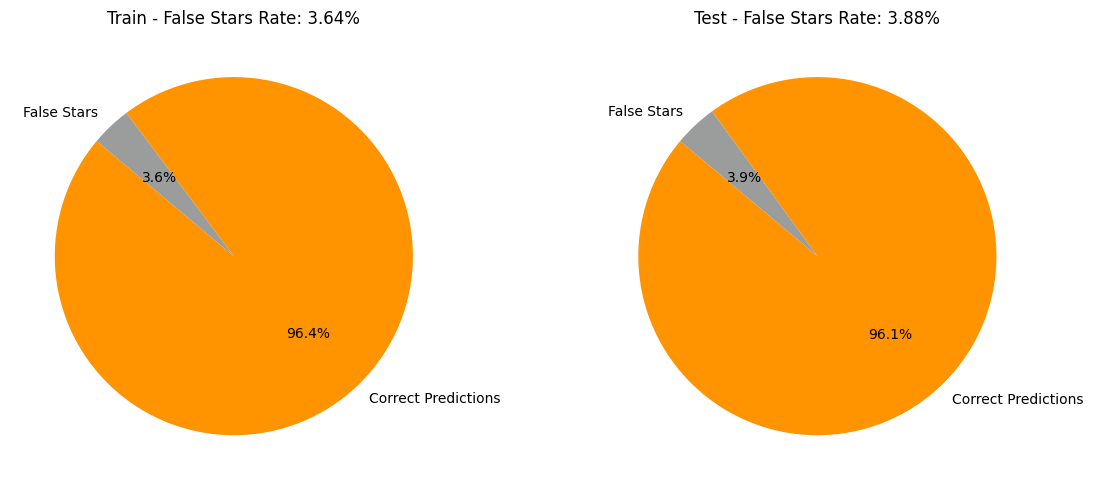

In [21]:
##Train
false_stars_train = conf_matrix_values_train[1][0]
true_galaxies_train = conf_matrix_values_train[1][1]

false_stars_train_rate = ((false_stars_train)/(false_stars_train + true_galaxies_train))*100
false_stars_train_rate = round(false_stars_train_rate,2)


##Test
false_stars_test = conf_matrix_values_test[1][0]
true_galaxies_test = conf_matrix_values_test[1][1]

false_stars_test_rate = ((false_stars_test)/(false_stars_test + true_galaxies_test))*100
false_stars_test_rate = round(false_stars_test_rate,2)


#PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  #Create two plots in 1 line

labels_train = ["Correct Predictions", "False Stars"]
sizes_train = [100 - false_stars_train_rate, false_stars_train_rate]
colors_train = ["#ff9300", "#9b9c9c"]
axes[0].pie(sizes_train, labels=labels_train, colors=colors_train, autopct='%1.1f%%', startangle=140)
axes[0].set_title(f"Train - False Stars Rate: {false_stars_train_rate}%")

# Pie Chart para Test
labels_test = ["Correct Predictions", "False Stars"]
sizes_test = [100 - false_stars_test_rate, false_stars_test_rate]
colors_test = ["#ff9300", "#9b9c9c"]
axes[1].pie(sizes_test, labels=labels_test, colors=colors_test, autopct='%1.1f%%', startangle=140)
axes[1].set_title(f"Test - False Stars Rate: {false_stars_test_rate}%")

plt.tight_layout()
plt.show()


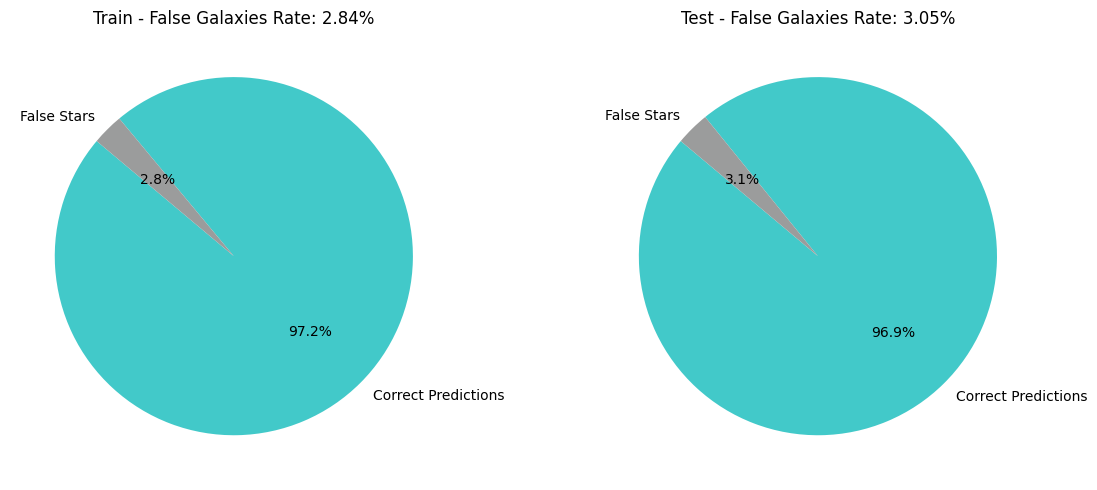

In [22]:
##Train
false_galaxies_train = conf_matrix_values_train[0][1]
true_stars_train = conf_matrix_values_train[0][0]

false_galaxies_train_rate = ((false_galaxies_train)/(false_galaxies_train + true_stars_train))*100
false_galaxies_train_rate = round(false_galaxies_train_rate,2)

##Test
false_galaxies_test = conf_matrix_values_test[0][1]
true_stars_test = conf_matrix_values_test[0][0]

false_galaxies_test_rate = ((false_galaxies_test)/(false_galaxies_test + true_stars_test))*100
false_galaxies_test_rate = round(false_galaxies_test_rate,2)


#PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  #Create two plots in 1 line

labels_train = ["Correct Predictions", "False Stars"]
sizes_train = [100 - false_galaxies_train_rate, false_galaxies_train_rate]
colors_train = ["#42c9c9", "#9b9c9c"]
axes[0].pie(sizes_train, labels=labels_train, colors=colors_train, autopct='%1.1f%%', startangle=140)
axes[0].set_title(f"Train - False Galaxies Rate: {false_galaxies_train_rate}%")

# Pie Chart para Test
labels_test = ["Correct Predictions", "False Stars"]
sizes_test = [100 - false_galaxies_test_rate, false_galaxies_test_rate]
colors_test = ["#42c9c9", "#9b9c9c"]
axes[1].pie(sizes_test, labels=labels_test, colors=colors_test, autopct='%1.1f%%', startangle=140)
axes[1].set_title(f"Test - False Galaxies Rate: {false_galaxies_test_rate}%")

plt.tight_layout()
plt.show()


As both rates (train and test) are very similar, the model is not overfitting so it is generalizing correctly the data. However, As the AUC value is very big, we can use **regularization** technique to make a more robust model. Regularization is intended to prevent overfitting by penalizing large coefficients and forcing the model to learn simpler, more generalizable patterns. There are different types of regularization (L1, L2 (same that L1 but squared), L1+L2, dropout,...). In this case, we will use L2 regularization because it is the most estable one and because all the selected variables are relevant. For that, it is necessary to add *regParam* to the Logistic Regression. The selected value 0.1 is because it is a simple model, it has not many variables (just 24).

In [23]:
lr_with_reg = LogisticRegression(labelCol="type", featuresCol="features", regParam=0.1)
model_with_reg = lr_with_reg.fit(train_data)

#Evaluate the model with regularization
predictions_with_reg = model_with_reg.transform(test_data)
auc_with_reg = evaluator.evaluate(predictions_with_reg)
print(f"Logistic Regression (Regularization): AUC = {auc_with_reg:.4f}")

Logistic Regression (Regularization): AUC = 0.8976


As we can see, the AUC has decreased from 0.9919 to 0.9066 (in test). This will be good for the model to learn more generalizable patterns and not to overfit.

## PCA

PCA is a technique that is used to reduce the dimensionality to simplify a large data set into a smaller one while maintaining significant patterns and trends. Trying to simplify the data we have, we are going to apply this technique. In this case, we will eliinate objID, ra, dec, flags and clean columns because we will not use it to train the models. Moreover, these features do not give us any information to classify the inspected object into a star or galaxy.

In [24]:
df_filtered = df.drop(*["objID", "flags", "clean", "ra", "dec"])
df_filtered.show()

+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---------+-----------+------------+----------+---------+---------+----------+----------+---------+
|type|petroRad_u|petroRad_g|petroRad_r|petroRad_i|petroRad_z|modelMag_u|modelMag_g|modelMag_r|modelMag_i|modelMag_z|psfMag_u|psfMag_g|psfMag_r|psfMag_i|psfMag_z|      u_g|        g_r|         r_i|       i_z|fracDeV_u|fracDeV_g| fracDeV_r| fracDeV_i|fracDeV_z|
+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---------+-----------+------------+----------+---------+---------+----------+----------+---------+
|   0|  2.292105|  1.707611|   1.64852|  1.665384|   1.72895|  21.24142|  18.88045|  17.57188|   16.3516|  15.70342|21.18578|18.87796|17.58161|16.35225|15.70951| 2.360977|   1.308565|    1.220278|  0.648181|      0.0|   

We are going to check the number of columns and rows in the dataset. Additionally, we will calculate the rank of the matrix, which gives us the maximum number of linearly independent columns. In other words, the rank indicates how many columns provide unique information that cannot be expressed as a linear combination of the other columns (without linear dependence).

In [ ]:
import numpy as np

df_filtered = df_filtered.toPandas()
n_rows, n_cols = df_filtered.shape
X = df_filtered.drop(columns = ["type"])
Y = df_filtered["type"]

X_rank = np.linalg.matrix_rank(X)
print(f"Number of rows: {n_rows}")
print(f"Number of columns: {n_cols}")
print(f"Matrix rank: {X_rank}")

Number of rows: 100000
Number of columns: 25
Matrix rank: 9


We get a rank of 9, which means that from all the 25 characteristics only 9 have the main variability of the data; just 9 columns are linearly indendent.

In [ ]:
from sklearn.model_selection import train_test_split

#Split the data: train (80%) and test (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=132)

print("Size of X_train:", X_train.shape)
print("Size of X_test:", X_test.shape)


Size of X_train: (80000, 24)
Size of X_test: (20000, 24)


In [ ]:
from sklearn.preprocessing import StandardScaler

#Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #We fit just with the train data
X_test_scaled = scaler.transform(X_test)

We want to get the best K value in order to get the best representation of the data (without losing much information) but having less columns.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

#Define different K values we want to try
Ks = np.arange(1, X_rank)  #From 1 to the rank + 1
RMSE_train = np.zeros(len(Ks))
RMSE_test = np.zeros(len(Ks))

#For each k value we apply the PCA
for index, K in enumerate(Ks):
    pca = PCA(n_components=K)
    
    #Reduce dimensionality in train
    Xtrain_pca = pca.fit_transform(X_train_scaled)
    #Reconstruct the data and calculate RMSE
    Xtrain_proj = pca.inverse_transform(Xtrain_pca)
    RMSE_train[index] = mean_squared_error(X_train_scaled, Xtrain_proj)

    #The same with test
    Xtest_pca = pca.transform(X_test_scaled) #The difference is that we do not fit in the test
    Xtest_proj = pca.inverse_transform(Xtest_pca)
    RMSE_test[index] = mean_squared_error(X_test_scaled, Xtest_proj)


print(RMSE_train)
print(RMSE_test)


NameError: name 'X_train_scaled' is not defined

As it is obvious, the RMSE is reduced while adding the components, because we are adding more information. We can see that the difference between RMSE in train and test is not big, which is good because it is indicating that the model is not overfitting. 

Now, we are going to calculate the explained variance and the acummulated explained variance to help us to select the amount of components.

In [29]:
import pandas as pd

# Calcular la varianza explicada y acumulada
pca = PCA(n_components=X_rank)  # Ajustamos PCA para obtener todos los componentes
pca.fit(X_train_scaled)

exp_variance = pd.DataFrame(data=pca.explained_variance_ratio_,
                            index=['PC' + str(n_pca + 1) for n_pca in range(pca.n_components)],
                            columns=['Exp_variance'])

exp_variance['cum_Exp_variance'] = exp_variance['Exp_variance'].cumsum()

# Muestra los primeros 20 componentes
exp_variance.head(20)


,Exp_variance,cum_Exp_variance
PC1,0.316303,0.316303
PC2,0.162346,0.478650
PC3,0.148205,0.626855
PC4,0.063078,0.689933
PC5,0.061439,0.751372
PC6,0.043166,0.794538
PC7,0.041512,0.836049
PC8,0.038786,0.874835
PC9,0.038527,0.913361


We can see that with 9 components (the rank) the explained variance is around 91%, which is really good taking into account that we reduced from 25 columns to 9. However, we will plot it in order to see it and to make a more intuitive selection for the k value.

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

#Threshold to know the acumulated variance
threshold = 0.9

#Get the first index fir k where we get the selected theshold
optimal_k = exp_variance[exp_variance['cum_Exp_variance'] >= threshold].index[0]

#Plot it
sns.barplot(data=exp_variance, x=exp_variance.index, y='Exp_variance', color='gray')
sns.lineplot(data=exp_variance, x=exp_variance.index, y='cum_Exp_variance', color='blue', label='Cumulative Proportion')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xticks(rotation=90)
plt.legend()
plt.show()

print(f"Optimal k (number of components) based on 90% variance: {optimal_k}")


NameError: name 'exp_variance' is not defined

After following this, the optimal value for k is 9. Taking this into account, we are going to follow the same approach than before to look the best model.

In [ ]:
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

df_spark = spark.createDataFrame(df_filtered)

features_pca = df_spark.columns[1:]#We don't get the type beacuse is the result we want to get.

assembler_pca = VectorAssembler(inputCols = features_pca, outputCol = "features") #Convert features list as a vector
df_ml_model_pca = assembler_pca.transform(df_spark) #Apply transformation
df_ml_model_pca = df_ml_model_pca.select("features", "type")

df_ml_model_pca.head(5)


[Row(features=DenseVector([2.2921, 1.7076, 1.6485, 1.6654, 1.729, 21.2414, 18.8804, 17.5719, 16.3516, 15.7034, 21.1858, 18.878, 17.5816, 16.3522, 15.7095, 2.361, 1.3086, 1.2203, 0.6482, 0.0, 0.0, 1.0, 0.0, 0.0]), type=0),
 Row(features=DenseVector([1.4166, 1.7066, 1.8061, 1.6989, 1.59, 20.9405, 19.8125, 19.5077, 19.4671, 19.4443, 20.93, 19.8136, 19.5282, 19.4942, 19.4514, 1.128, 0.3047, 0.0407, 0.0228, 0.0, 0.0, 1.0, 0.9682, 0.0]), type=0),
 Row(features=DenseVector([1.7877, 2.5021, 2.5175, 2.4911, 2.9252, 20.9695, 20.2914, 19.3678, 18.8639, 18.4555, 21.3143, 20.775, 19.8938, 19.3627, 18.9478, 0.6781, 0.9236, 0.5039, 0.4084, 1.0, 0.5368, 0.631, 0.484, 0.417]), type=1),
 Row(features=DenseVector([3.0812, 1.5711, 1.6398, 1.752, 1.6438, 22.722, 20.319, 19.0538, 18.4886, 18.2401, 22.6338, 20.3004, 19.0465, 18.4912, 18.2252, 2.4031, 1.2651, 0.5652, 0.2485, 1.0, 1.0, 1.0, 1.0, 0.0]), type=0),
 Row(features=DenseVector([2.6302, 2.494, 2.2824, 2.8315, 3.7433, 20.8501, 20.6889, 20.2304, 20.26, 

In [32]:
train_data_pca, test_data_pca = df_ml_model_pca.randomSplit([0.8, 0.2], seed = 132)

In [33]:
#Define different models
models = {
    "Logistic Regression": LogisticRegression(labelCol="type", featuresCol="features"),
    "Decision Tree": DecisionTreeClassifier(labelCol="type", featuresCol="features"),
    "Random Forest": RandomForestClassifier(labelCol="type", featuresCol="features", numTrees=5),
    "Gradient Boosted Trees": GBTClassifier(labelCol="type", featuresCol="features"),
    "Linear SVM": LinearSVC(labelCol="type", featuresCol="features")
}

In [ ]:
#Define PCA with the optimized k value
pca = PCA(k=optimal_k, inputCol="features", outputCol="pca_features")

#Select the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="type", metricName="areaUnderROC")

#Apply PCA and train the models
for name, model in models.items():
    #Create the pipeline so first it will apply PCA and the the model
    pipeline = Pipeline(stages=[pca, model])
    
    #Fit the model with the train data
    model_trained = pipeline.fit(train_data_pca)
    
    #Make predictions with the test data
    predictions = model_trained.transform(test_data_pca)
    
    #Evaluate the model the same way than before
    auc = evaluator.evaluate(predictions)
    print(f"{name}: AUC = {auc:.4f}")


Logistic Regression: AUC = 0.9947


Decision Tree: AUC = 0.9767


Random Forest: AUC = 0.9890


Gradient Boosted Trees: AUC = 0.9932


Linear SVM: AUC = 0.9942


The model Linear SVM does not have 'probability' column so it will not be in the graphic.


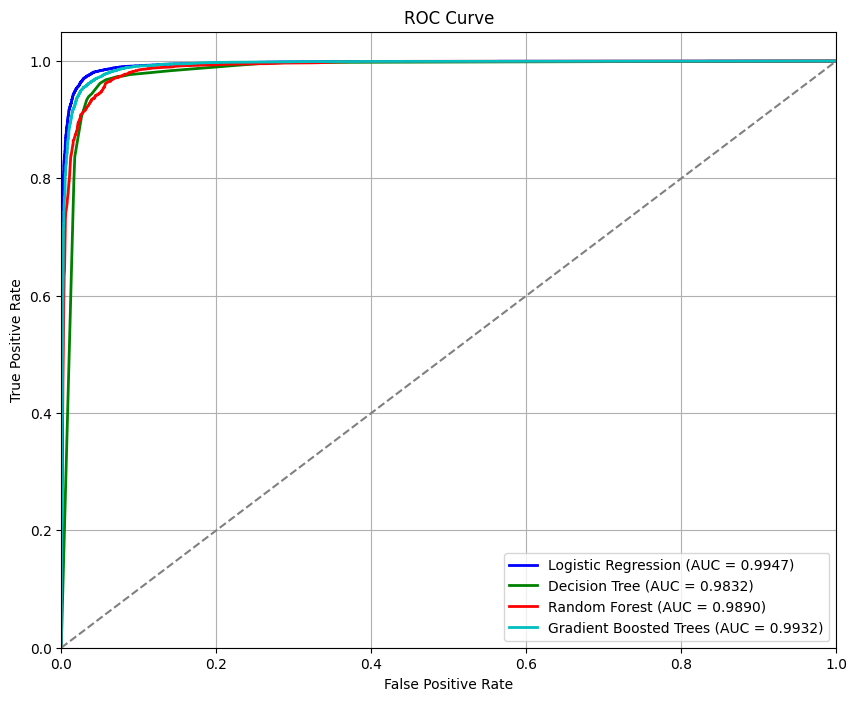

In [35]:
from sklearn.metrics import roc_curve, auc

#Create the figure
plt.figure(figsize=(10, 8))

#Different colors for the different models
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

#For each model compute the AUC
for idx, (name, model) in enumerate(models.items()):
    model_trained = model.fit(train_data_pca)
    predictions = model_trained.transform(test_data_pca) #Predicted class (0 or 1)

    #Check if the model has "probability" column because some of them (SVG for example) do not
    if "probability" in predictions.columns:
        #Get the whole probability vector, convert it into rdd and select the probability for the positive (real) prediction
        prob_positives = predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()
        #Get the label for each prediction
        true_labels = predictions.select("type").rdd.map(lambda row: row[0]).collect()

        #Calculate ROC curve
        fpr, tpr, _ = roc_curve(true_labels, prob_positives)
        roc_auc = auc(fpr, tpr)

        #Plot it
        plt.plot(fpr, tpr, color=colors[idx % len(colors)], lw=2, label=f'{name} (AUC = {roc_auc:.4f})')
    else:
        print(f"The model {name} does not have 'probability' column so it will not be in the graphic.")

#Different parameters to personalize the plot
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  #Diagonal line of "random"
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()

plt.show()

In [37]:
lr = LogisticRegression(labelCol="type", featuresCol="features")
lr_model = lr.fit(train_data_pca)

predictions_log_train_pca = lr_model.transform(train_data_pca)
predictions_log_test_pca = lr_model.transform(test_data_pca)

auc_train_pca = evaluator.evaluate(predictions_log_train_pca)
auc_test_pca = evaluator.evaluate(predictions_log_test_pca)

print(f"Logistic Regression (Train): AUC = {auc_train_pca:.4f}\n")
print(f"Logistic Regression (Test): AUC = {auc_test_pca:.4f}")

Logistic Regression (Train): AUC = 0.9946

Logistic Regression (Test): AUC = 0.9947


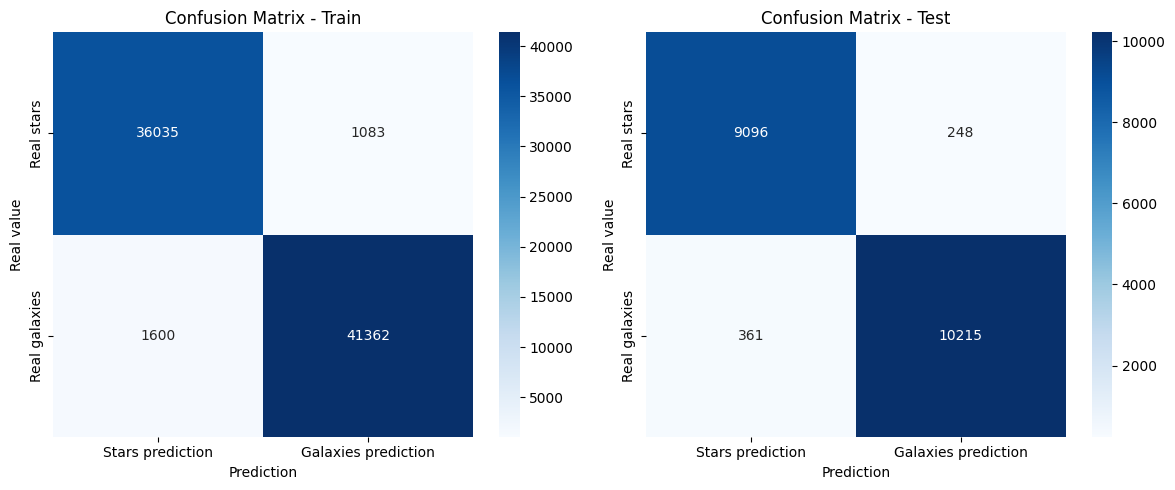

In [38]:
from pyspark.sql import functions as F
import seaborn as sns
import numpy as np

#Divide true positives, true negatives, false positives and false negatives
##Train
true_galaxies_train_pca = predictions_log_train_pca.filter((F.col("type") == 1) & (F.col("prediction") == 1)).count()
true_stars_train_pca = predictions_log_train_pca.filter((F.col("type") == 0) & (F.col("prediction") == 0)).count()
false_stars_train_pca = predictions_log_train_pca.filter((F.col("type") == 0) & (F.col("prediction") == 1)).count()
false_galaxies_train_pca = predictions_log_train_pca.filter((F.col("type") == 1) & (F.col("prediction") == 0)).count()

#Creating the confusion matrix
conf_matrix_values_train_pca = [[true_stars_train_pca, false_stars_train_pca], [false_galaxies_train_pca, true_galaxies_train_pca]]


##Test
true_galaxies_test_pca = predictions_log_test_pca.filter((F.col("type") == 1) & (F.col("prediction") == 1)).count()
true_stars_test_pca = predictions_log_test_pca.filter((F.col("type") == 0) & (F.col("prediction") == 0)).count()
false_stars_test_pca = predictions_log_test_pca.filter((F.col("type") == 0) & (F.col("prediction") == 1)).count()
false_galaxies_test_pca = predictions_log_test_pca.filter((F.col("type") == 1) & (F.col("prediction") == 0)).count()

#Creating the confusion matrix
conf_matrix_values_test_pca = [[true_stars_test_pca, false_stars_test_pca], [false_galaxies_test_pca, true_galaxies_test_pca]]


#Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  #Create two plots in 1 line

#Train confusion matrix
ax1 = sns.heatmap(np.array(conf_matrix_values_train_pca), annot=True, fmt="d", cmap="Blues",
                   xticklabels=["Stars prediction", "Galaxies prediction"],
                   yticklabels=["Real stars", "Real galaxies"], ax=axes[0]) #Put in the axe 0, the left one
ax1.set_xlabel("Prediction")
ax1.set_ylabel("Real value")
ax1.set_title("Confusion Matrix - Train")

#Test confusion matrix
ax2 = sns.heatmap(np.array(conf_matrix_values_test_pca), annot=True, fmt="d", cmap="Blues",
                   xticklabels=["Stars prediction", "Galaxies prediction"],
                   yticklabels=["Real stars", "Real galaxies"], ax=axes[1]) #Put in the axe 0, the right one
ax2.set_xlabel("Prediction")
ax2.set_ylabel("Real value")
ax2.set_title("Confusion Matrix - Test")


plt.tight_layout()
plt.show()


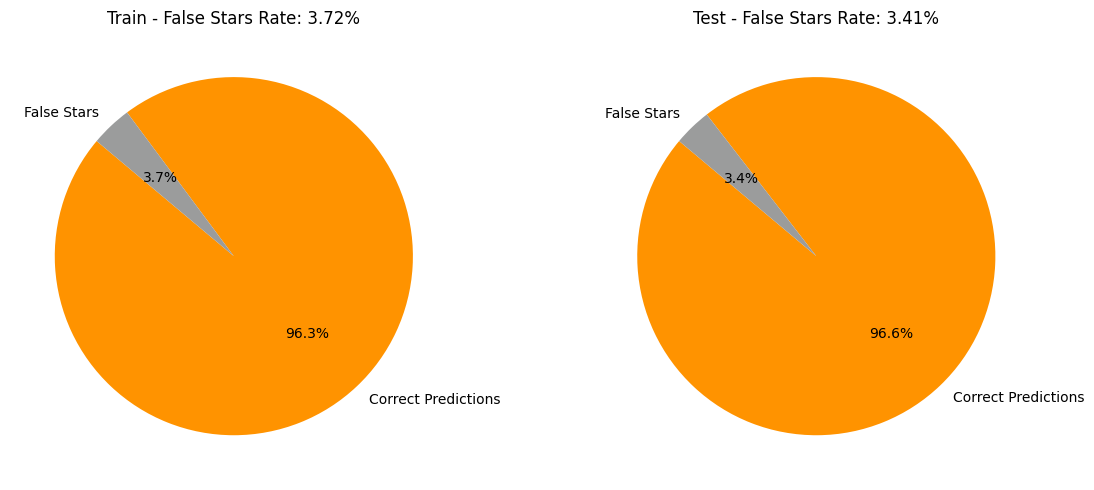

In [39]:
##Train
false_stars_train_pca = conf_matrix_values_train_pca[1][0]
true_galaxies_train_pca = conf_matrix_values_train_pca[1][1]

false_stars_train_rate_pca = ((false_stars_train_pca)/(false_stars_train_pca + true_galaxies_train_pca))*100
false_stars_train_rate_pca = round(false_stars_train_rate_pca,2)


##Test
false_stars_test_pca = conf_matrix_values_test_pca[1][0]
true_galaxies_test_pca = conf_matrix_values_test_pca[1][1]

false_stars_test_rate_pca = ((false_stars_test_pca)/(false_stars_test_pca + true_galaxies_test_pca))*100
false_stars_test_rate_pca = round(false_stars_test_rate_pca,2)


#PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  #Create two plots in 1 line

labels_train = ["Correct Predictions", "False Stars"]
sizes_train = [100 - false_stars_train_rate_pca, false_stars_train_rate_pca]
colors_train = ["#ff9300", "#9b9c9c"]
axes[0].pie(sizes_train, labels=labels_train, colors=colors_train, autopct='%1.1f%%', startangle=140)
axes[0].set_title(f"Train - False Stars Rate: {false_stars_train_rate_pca}%")

# Pie Chart para Test
labels_test = ["Correct Predictions", "False Stars"]
sizes_test = [100 - false_stars_test_rate_pca, false_stars_test_rate_pca]
colors_test = ["#ff9300", "#9b9c9c"]
axes[1].pie(sizes_test, labels=labels_test, colors=colors_test, autopct='%1.1f%%', startangle=140)
axes[1].set_title(f"Test - False Stars Rate: {false_stars_test_rate_pca}%")

plt.tight_layout()
plt.show()


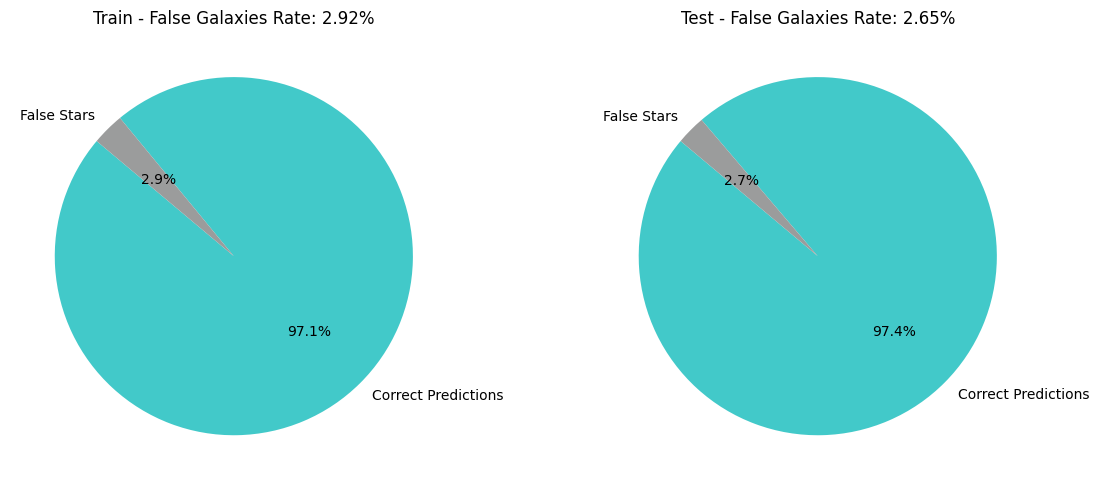

In [43]:
##Train
false_galaxies_train_pca = conf_matrix_values_train_pca[0][1]
true_stars_train_pca = conf_matrix_values_train_pca[0][0]

false_galaxies_train_rate_pca = ((false_galaxies_train_pca)/(false_galaxies_train_pca + true_stars_train_pca))*100
false_galaxies_train_rate_pca = round(false_galaxies_train_rate_pca,2)

##Test
false_galaxies_test_pca = conf_matrix_values_test_pca[0][1]
true_stars_test_pca = conf_matrix_values_test_pca[0][0]

false_galaxies_test_rate_pca = ((false_galaxies_test_pca)/(false_galaxies_test_pca + true_stars_test_pca))*100
false_galaxies_test_rate_pca = round(false_galaxies_test_rate_pca,2)


#PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  #Create two plots in 1 line

labels_train = ["Correct Predictions", "False Stars"]
sizes_train = [100 - false_galaxies_train_rate_pca, false_galaxies_train_rate_pca]
colors_train = ["#42c9c9", "#9b9c9c"]
axes[0].pie(sizes_train, labels=labels_train, colors=colors_train, autopct='%1.1f%%', startangle=140)
axes[0].set_title(f"Train - False Galaxies Rate: {false_galaxies_train_rate_pca}%")

# Pie Chart para Test
labels_test = ["Correct Predictions", "False Stars"]
sizes_test = [100 - false_galaxies_test_rate_pca, false_galaxies_test_rate_pca]
colors_test = ["#42c9c9", "#9b9c9c"]
axes[1].pie(sizes_test, labels=labels_test, colors=colors_test, autopct='%1.1f%%', startangle=140)
axes[1].set_title(f"Test - False Galaxies Rate: {false_galaxies_test_rate_pca}%")

plt.tight_layout()
plt.show()


In [51]:
# Obtener las cargas de las componentes principales (component loadings)
component_loadings = pd.DataFrame(pca.components_.T, 
                                  columns=[f'PC{i+1}' for i in range(pca.n_components_)], 
                                  index=X.columns)

# Verifica cómo se ve el DataFrame
print(component_loadings.head())

                 PC1       PC2       PC3       PC4       PC5       PC6  \
petroRad_u -0.000360  0.004023  0.026511  0.016793  0.371626  0.288584   
petroRad_g  0.001060  0.006497  0.071748  0.012464  0.500438 -0.048816   
petroRad_r  0.000597  0.005062  0.055357  0.016962  0.562522 -0.090894   
petroRad_i -0.000224  0.005493  0.050480  0.008180  0.359785 -0.174294   
petroRad_z  0.000837  0.005710  0.063746  0.010410  0.354391 -0.115476   

                 PC7       PC8       PC9  
petroRad_u -0.254204 -0.514970 -0.344395  
petroRad_g  0.049582 -0.114906 -0.118008  
petroRad_r  0.127157 -0.090974 -0.052706  
petroRad_i  0.045586  0.770321 -0.302821  
petroRad_z -0.168587  0.008015  0.862079  


In [52]:
# Para cada componente, obtener las 5 características más importantes
top_features = component_loadings.abs().nlargest(5, 'PC1').index  # top 5 para la primera componente
print("Top features contributing to PC1:", top_features)


Top features contributing to PC1: Index(['psfMag_i', 'modelMag_i', 'r_i', 'fracDeV_i', 'psfMag_z'], dtype='object')


In [53]:
# Seleccionar las columnas más importantes para la correlación
top_features_df = X[top_features]

# Calcular la matriz de correlación
correlation_matrix = top_features_df.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)


            psfMag_i  modelMag_i       r_i  fracDeV_i  psfMag_z
psfMag_i    1.000000    0.999995 -0.999952   0.999949  0.785881
modelMag_i  0.999995    1.000000 -0.999961   0.999957  0.785872
r_i        -0.999952   -0.999961  1.000000  -0.999992 -0.785796
fracDeV_i   0.999949    0.999957 -0.999992   1.000000  0.785797
psfMag_z    0.785881    0.785872 -0.785796   0.785797  1.000000


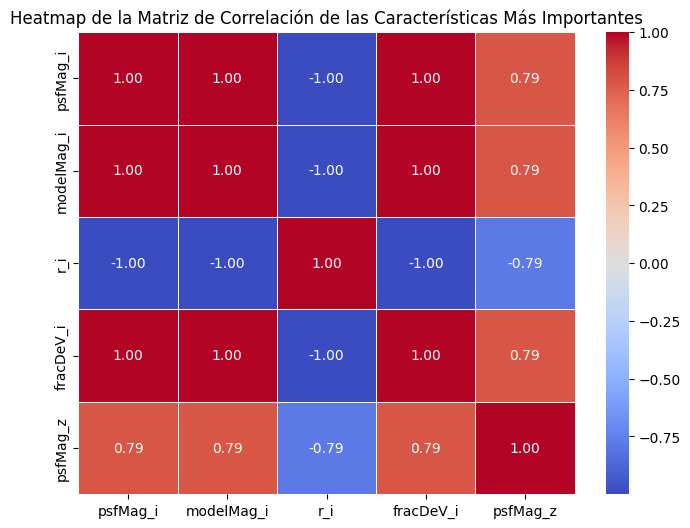

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap de la Matriz de Correlación de las Características Más Importantes")
plt.show()


In [67]:
# Para cada componente, obtener las 5 características más importantes
top_features = component_loadings.abs().nlargest(5, 'PC4').index  # top 5 para la primera componente
print("Top features contributing to PC1:", top_features)


Top features contributing to PC1: Index(['i_z', 'fracDeV_z', 'modelMag_z', 'psfMag_z', 'r_i'], dtype='object')


In [68]:
# Seleccionar las columnas más importantes para la correlación
top_features_df = X[top_features]

# Calcular la matriz de correlación
correlation_matrix = top_features_df.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)


                 i_z  fracDeV_z  modelMag_z  psfMag_z       r_i
i_z         1.000000  -0.000132   -0.000120 -0.000120 -0.618318
fracDeV_z  -0.000132   1.000000    0.999926  0.999918 -0.785831
modelMag_z -0.000120   0.999926    1.000000  0.999994 -0.785805
psfMag_z   -0.000120   0.999918    0.999994  1.000000 -0.785796
r_i        -0.618318  -0.785831   -0.785805 -0.785796  1.000000


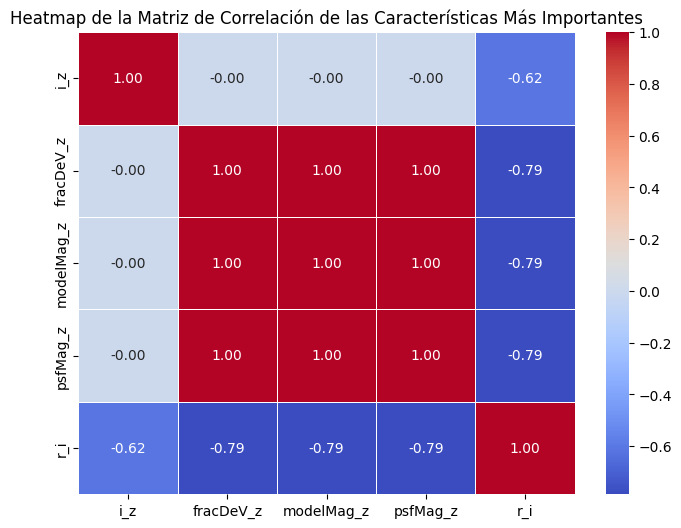

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap de la Matriz de Correlación de las Características Más Importantes")
plt.show()


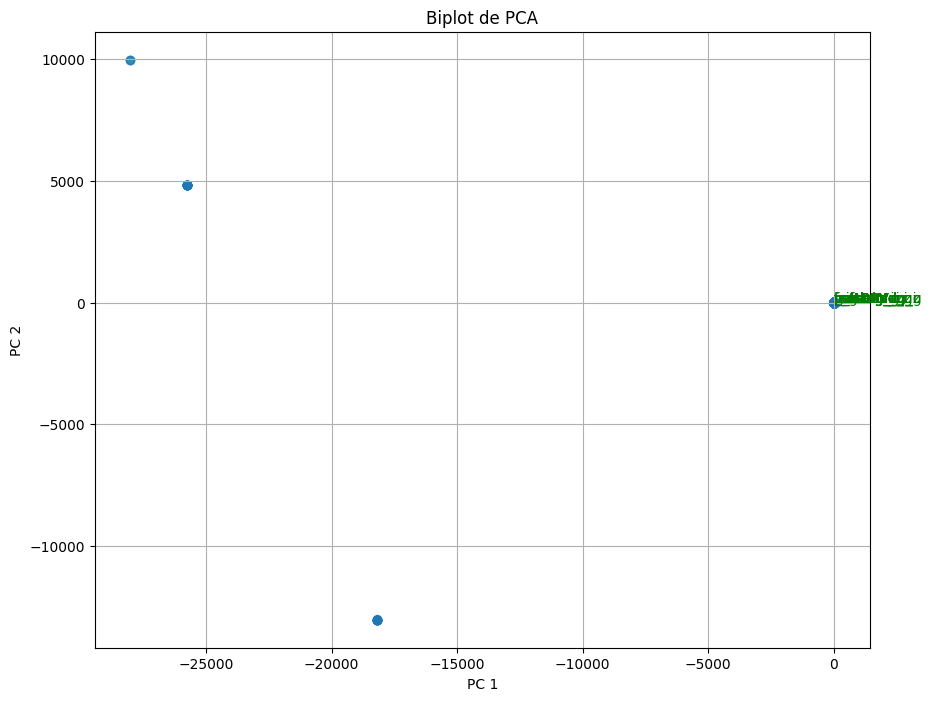

In [72]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
for i, colname in enumerate(X.columns):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i],
              color='r', alpha=0.5, head_width=0.1)
    plt.text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15, colname, color='g')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Biplot de PCA")
plt.grid()
plt.show()


# Images

As I need also de images, I have downloaded from https://skyserver.sdss.org/dr18, specifying with a request:
- the location of the object (with right ascension (RA) and declination (dec))
- the zoom of the picture (scale)
- the dimmensions of the photo (with and height)

These images will be saved into a "images" folder splitted into train and test and each one splitted as galaxies or stars. In a visual way would be:

![](notebookImages/folderSchema.png)
   


In [ ]:
!python download_images.py

## Data preprocessing

First it is necessary to know the amount of channels we are going to work with. For that, we are going to take one photo and verify it.

In [ ]:
import cv2
import os
import config

image_path = config.IMAGES_PATH + "/train/star"

#Get all the images
images = [f for f in os.listdir(image_path) if f.endswith((".jpg"))]

image_path = os.path.join(image_path, images[0]) #Get the first photo

image = cv2.imread(image_path) #Read the first photo

if len(image.shape) == 2:
    print("Image with grayscale.")
elif len(image.shape) == 3 and image.shape[2] == 3:
    print("Image with 3 channels (RGB).")
elif len(image.shape) == 3 and image.shape[2] == 4:
    print("Image with 4 channels (RGBA).") #RGB + Alpha (opacity of the image)

As we can see our images have 3 channels RGB. Now, we are going to normalize the pixels values  because we are going to work with a neural network and usually this improves the model performance and facilitate the process of learning. 

In [ ]:
import torch
import numpy as np
from torchvision import datasets
from torchvision import datasets, transforms

def calculate_mean_std(dataloader):
    mean = 0.0
    std = 0.0
    total_images = 0

    for img, _ in dataloader:
        batch_samples = img.size(0)  #Amount of images per batch
        img = img.view(batch_samples, img.size(1), -1)  # Reorganizar para calcular sobre todas las imágenes del batch
        mean += img.mean(2).mean(0)  #Mean by channel
        std += img.std(2).std(0)  #std per channel Desviación estándar por canal

        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

In [ ]:
from torch.utils.data import DataLoader

#Dataset and loader for all the images
full_dataset = datasets.ImageFolder(config.IMAGES_PATH, transform=transforms.ToTensor())
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

#Calculate the mean and std to normalize the images
mean, std = calculate_mean_std(full_loader)

#Transform the images (convert them into tensors + normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

#Get the train, test and validation datasets
train_dataset = datasets.ImageFolder(root=config.IMAGES_PATH+"/train", transform=transform)
test_dataset = datasets.ImageFolder(root=config.IMAGES_PATH+"/test", transform=transform)
validation_dataset = datasets.ImageFolder(root=config.IMAGES_PATH+"/validation", transform=transform)

#Create the DataLoader for train, test and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

## Analysis

First, we will verify if the images a re correctly imported and transformed (convert them into tensors and normalize them).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def show_images(data_loader, mean, std, num_images):
    data_iter = iter(data_loader) #Convert dataLoader into an iterable
    images, labels = next(data_iter) #Get the next batch (a set of images processed simultaneously)

    #Plot to show images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    
    #Ensure that the mean and std is arrays of numpy
    mean = np.array(mean.tolist())
    std = np.array(std.tolist())
    
    #For each image
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy()  #Change the format of images, matplolib needs (H, W, C)
        
        #Undo the normalization to see correctly the images
        image = image * std + mean
        
        image = np.clip(image, 0, 1) #Ensure that images pixels are between 0 and 1 values (to see correctly the image)
        #If a value is less than 0, that pixel would be fully black or with errors.
        #If a value is bigger than 1 the colors could be saturated.
        
        #Plot the image
        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')

    plt.show()

show_images(train_loader, mean, std, num_images=8)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

class_names = full_dataset.classes  #Class names list
class_counts = {class_name: 0 for class_name in class_names}  #Create the dictionary to count the amount of images for each class

#Count images by class
for _, label in full_dataset.samples:  #List (image_path, label)
    class_name = class_names[label]
    class_counts[class_name] += 1

#Convert it into a dataFrame
data = pd.DataFrame({
    "Type": list(class_counts.keys()),
    "Count": list(class_counts.values())
})

#Calculate the percentage
total_count = data["Count"].sum()
data["Percentage"] = (data["Count"] / total_count) * 100

colors = ["#d7bde2", "#abebc6", "#abb2b9"]

#Plot the Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(
    data["Count"],
    labels=data["Type"],
    autopct="%1.1f%%",
    colors=colors,
    startangle=140,
    wedgeprops={"edgecolor": "black"}
)

plt.title("Distribution of data by sets")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

class_names = train_dataset.classes  #List with class names
class_counts = {class_name: 0 for class_name in class_names}  #Create the dictionary to count the amount of images for each class

#Count images by class
for _, label in train_dataset.samples: #List (image_path, label)
    class_name = class_names[label]
    class_counts[class_name] += 1 #Count the amount of objects for each class

#Convert it into a Dataframe
data = pd.DataFrame({
    "Type": list(class_counts.keys()),
    "Count": list(class_counts.values())
})

#Reverse to have the same shape than before
data = data.iloc[::-1].reset_index(drop=True)

#Plot
plt.figure(figsize=(8, 6))
plt.bar(data["Type"], data["Count"], color=["#ff9300", "#42c9c9"], edgecolor=["#cc7400", "#329999"])
plt.xlabel("Object Type")
plt.ylabel("Count")
plt.title("Total of Stars and Galaxies in training (Images)")

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to count images and generate the DataFrame
def get_class_counts(dataset):
    class_names = dataset.classes  # List with class names (galaxy, star)
    class_counts = {class_name: 0 for class_name in class_names}  # Create dictionary to count images per class

    # Count images by class
    for _, label in dataset.samples:  # List (image_path, label)
        class_name = class_names[label]
        class_counts[class_name] += 1

    # Convert to DataFrame and calculate percentage
    data = pd.DataFrame({
        "Type": list(class_counts.keys()),
        "Count": list(class_counts.values())
    })
    data["Percentage"] = (data["Count"] / data["Count"].sum()) * 100

    return data

# Get the DataFrames for each dataset
train_data = get_class_counts(train_dataset)
val_data = get_class_counts(validation_dataset)
test_data = get_class_counts(test_dataset)

# Set up the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors for pie chart and their corresponding border colors
colors = ["#42c9c9", "#ff9300"]  # Fill colors
edge_colors = ["#329999", "#cc7400"]  # Darker border colors

# Datasets and titles
datasets = [(train_data, "Training Set"), (val_data, "Validation Set"), (test_data, "Test Set")]

# Plot each dataset in a subplot
for ax, (data, title) in zip(axes, datasets):
    wedges, texts, autotexts = ax.pie(
        data["Count"],
        labels=data["Type"],
        autopct="%1.1f%%",
        colors=colors,
        startangle=140,
        wedgeprops={"linewidth": 2}  # General border thickness
    )

    # Set custom edge colors
    for wedge, edge_color in zip(wedges, edge_colors):
        wedge.set_edgecolor(edge_color)

    ax.set_title(title)

# General title
plt.suptitle("Distribution of Stars and Galaxies in Datasets", fontsize=14)
plt.show()


### Model

#### Preparation

In [ ]:
import cnn
from torch.utils.tensorboard import SummaryWriter
import torch

#In case the gpu is accessible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Create the model and use the selected
model = cnn.CNN(num_classes=2)
model.to(device)

#Define the optimizer and the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

#Use tensorflow to see the loss functions plots and metrics
writer = SummaryWriter()

epochs = 100
cnn.train_model(train_loader, test_loader, model, optimizer, criterion, epochs, device, writer, checkpoint_path = "checkpointCNN.pth")

writer.close()

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
import cnn_se

#In case the gpu is accessible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Create the model and use the selected
model = cnn_se.CNNWithSE(num_classes=2)
model.to(device)

#Define the optimizer and the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

#Use tensorflow to see the loss functions plots and metrics
writer = SummaryWriter()


epochs = 100
cnn_se.train_model(train_loader, test_loader, model, optimizer, criterion, epochs, device, writer, checkpoint_path = "checkpointCNN_SE.pth")


writer.close()


After comparing both, we can see that the SE blocks improve slightly the performance. The yellow one is the simple CNN while the green CNN + SE blocks.

![](notebookImages/performance1.png)


In [ ]:
from sklearn.metrics import roc_auc_score

# Evaluación en el conjunto de test
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Obtener probabilidades de la clase positiva (galaxia)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilidad de clase 1 (galaxia)

        all_probs.extend(probs.cpu().numpy())  # Convertir a numpy
        all_labels.extend(labels.cpu().numpy())  # Guardar etiquetas verdaderas

# Calcular AUC-ROC
auc_score = roc_auc_score(all_labels, all_probs)
print(f"AUC-ROC: {auc_score:.4f}")

In [ ]:
# Primero importa el archivo de optimización
from optimize_hyperparameters import optimize_hyperparameters

# Asegúrate de que tus DataLoaders estén listos antes de llamarlo
# Si ya has cargado los datos y hecho la normalización, como mencionaste en tu código, esto debería funcionar

# Llamar a la función de optimización de hiperparámetros de Optuna
best_params = optimize_hyperparameters(train_loader, validation_loader)

# Imprimir los mejores parámetros
print("Best hyperparameters found:", best_params)